# Local Quantum Friction

## Introduction

A common problem with both simulations and experiments is to prepare a quantum system in the ground state.  Experimentally one can usually obtain a good approximation of the ground state by allowing high-energy particles to evaporate at the cost of losing particles.  (The real problem is when one wants to prepare a ground state with a single particle.)  Here we discuss a particular technique useful for finding the ground state of quantum simulations suitable for application to large systems that require high-performance computing (HPC) clusters.

## Fermionic DFT

With simulations, one has a variety of techniques, but with varying computational cost.  The motivation for the method described here is that of finding the ground state in a systems of fermions using density functional theory (DFT).  The state of a fermionic DFT consists of a set of single-particle states $\psi = \{\psi_n\}$.  Each of these single-particle states $\psi_n$ must be orthogonal to each of the others to ensure that the Pauli exclusion principle is satisfied.  (The physical state used in the DFT is a Slater determinant of these "orbitals".)  The challend is that, for larger systems, these states can comprise terrabytes of data, and must be distributed over a HPC cluster.  Most of the minimization techniques destroy the orthogonality of these single-particle states, requireing continual reorthogonalization (i.e. via the Gram-Schmidt process) which communication between all of the compute nodes.  Communication is one of the slowest aspects of computing on a cluster, and this communication effectively prohibits the application of standard minimization techniques for large systems.

In contrast, real-time evolution by applying the Hamiltonian can be efficiently implemented efficiently.  Such evolution 

$$
  \newcommand{\I}{\mathrm{i}}
  \newcommand{\d}{\mathrm{d}}
  \newcommand{\vect}[1]{\vec{#1}}
  \newcommand{\op}[1]{\hat{#1}}
  \newcommand{\abs}[1]{\lvert#1\rvert}
  \newcommand{\pdiff}[2]{\frac{\partial #1}{\partial #2}}
  \newcommand{\ket}[1]{\lvert#1\rangle}
  \newcommand{\bra}[1]{\langle#1\rvert}
  \newcommand{\braket}[1]{\langle#1\rangle}
  \DeclareMathOperator{\Tr}{Tr}
  \I \hbar\pdiff{\psi_n}{t} = \op{H}\psi_n.
$$

requires communicating the same Hamiltonian $\op{H}[\{\psi_n\}]$ to each of the nodes, but this typically only requires sending the effective potential - the equivalent of a single wavefunction of information - to each of the nodes which is feasible for large states.  (Technically, this is computed by a single reduce operation over the cluster.)

The method of local quantum friction discussed here provides real-time evolution with a modified Hamiltonian $\op{H}_f$ so as to remove energy from the system while maintaining orthonormality of the single-particle states.  We shall demonstrate this technique here using bosons simulated with the GPE.  Since the bosonic DFT depends on a single wavefunction (sometimes called an "orbital free" DFT), one has access to the other techniques, but we proceed keeping the fermionic example in mind.

## Formulation

Consider the GPE: the ground state can be defined as a constrained variation of an energy functional $E[\psi]$ while fixing the particle number $N[\psi]$.  The variational condition defines the time-evolution of the system:

$$
  \I \hbar\pdiff{\psi}{t} 
  = (\op{H}[\psi] - \mu)\psi
  = \pdiff{(E[\psi] - \mu N[\psi])}{\psi^\dagger},\\
  E[\psi] = \int \d^3\vect{x}\left(
    \frac{\hbar^2\abs{\vect{\nabla}\psi}^2}{2m} 
    + \frac{g}{2}n^2(\vect{x})
    + V(\vect{x})n(\vect{x})
  \right),
  \qquad
  N[\psi] = \int \d^3{x}\; n(\vect{x}),\\
  n(\vect{x}) = \abs{\psi(\vect{x})}^2.
$$

This gives rise to the usual GPE effective Hamiltonian:

$$
  \op{H}[\psi] = \frac{-\hbar^2\nabla^2}{2m} + gn(\vect{x}) + V(\vect{x}).
$$

### Imaginary Time Cooling

The most straight-forward approach to the minimization problem is the method of steepest descent - going downhill:

$$
  \d \psi \propto -\pdiff{E[\psi]}{\psi^\dagger} \propto - \op{H}\psi.
$$

*Note: There is a slight subtlety here since we are minimizing a function of a complex field $\psi$.  A careful treatment breaking $\psi$ into real and imaginary parts coupled with the fact that the energy is a real symmetric function $E[\psi^\dagger, \psi] = E[\psi, \psi^\dagger]$ shows that $\d{\psi} \propto -\partial{E}/\partial{\psi^\dagger}$ indeed gives the correct descent diretion.*

Thus, we can implement a continuous gradient descent if we evolve

$$
  \hbar\pdiff{\psi}{\tau} = - \op{H}\psi = - \I\hbar \pdiff{\psi}{t}
$$

with respect $\tau = -\I t$ which is equivalent to our original evolution with respect to an "imaginary time" $t = \I \tau$.  Mathematically, this can be expressed by including a "cooling phase" in front of the evolution:

$$
  e^{\I\phi} \I\hbar \pdiff{\psi}{t} = \op{H}\psi.
$$

Real-time evolution is implemented when $e^{\I \phi} = 1$, while imaginary-time cooling is implemented when $e^{\I\phi} = \I$.  Complex-time evolution with $e^{\I\phi} \propto 1 + \epsilon \I$ can be used to mimic superfluid dynamics with dissipation.  This is implemented in the simulations through the cooling parameter $\epsilon$.  Imaginary time cooling is realized with large values of $\epsilon$.

Directly implementing evolution with an imaginary component to the phase will not only reduce the energy, but will also reduce the particle number.  Generally this is not desirable, so we must rescale the wave-function to restore the particle number.  Scaling the wavefunction $\psi \rightarrow s(t)\psi$ corresponds to a term in the evolution $\partial \psi/\partial t \propto s'(t)\psi$.  This can be implemented by adding a constant to Hamiltonian, aka a chemical potential:

$$
  e^{\I\phi} \I\hbar \pdiff{\psi}{t} = (\op{H} - \mu)\psi.
$$

A little investigation shows that one should take:

$$
  \mu(t) = \frac{\braket{\psi|\op{H}|\psi}}{\braket{\psi|\psi}}.
$$

Expressed in another way, we make the change in the state $\ket{\d\psi} \propto \op{H}\ket{\psi}$ orthogonal to $\ket{\psi}$ so that the state simply "rotates" without changing length:

$$
  \ket{\d\psi} \propto (\op{H} - \mu)\ket{\psi}, \qquad \braket{\d\psi|\psi} = 0.
$$

This immediately gives the condition $\mu = \braket{\op{H}}$ given above, which will preserve the normalization of the state no-matter what the cooling phase.  *Incidentally, even if one performs real-time evolution, using such a chemical potential can be numerically advantageous as it minimizes the phase evolution of the state.  This has not physical significance, but reduces numerical errors and allows one to use larger time-steps.*

### Example 1: Cooling

Run the following simulation of a highly-excited superfluid and explore the effect of the cooling phase.  The simulation starts with a BEC in a cylindrical trap rotating with a high angular velocity.  You can addjust the cooling parameter $\epsilon$ with the first slider.  For large amounts of cooling, you should see the system rapidly lose energy to form a set of orbiting vortices.

In [0]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

In [0]:
from mmf_setup.set_path import hgroot
from importlib import reload
from super_hydro.client import notebook;reload(notebook)
notebook.run(model='gpe.BEC', Nx=64, Ny=64)

### Quantum Friction

One can derive cooling from another perspective which allows the desired generalization.  Consider hoe the energy of the system $E[\psi]$ changes when we evolve the system with a "cooling" Hamiltonian $\op{H}_c = \op{H}_c^\dagger$, which we restrict:

$$
  \I\hbar \ket{\dot{\psi}} \equiv \I\hbar \pdiff{\ket{\psi}}{t}
  = \op{H}_{c}\ket{\psi}.
$$

The change in the energy is:

\begin{align}
  \dot{E} &= \bra{\dot{\psi}}\pdiff{E}{\bra{\psi}} + \pdiff{E}{\ket{\psi}}\ket{\dot{\psi}},\\
          &= \braket{\dot{\psi}|\op{H}|\psi} + \braket{\psi|\op{H}|\dot{\psi}},\\
          &= \frac{-\braket{\psi|\op{H}_c\op{H}|\psi} + \braket{\psi|\op{H}\op{H}_c|\psi}}{\I\hbar}
          = \frac{\braket{\psi|[\op{H},\op{H}_c]|\psi}}{\I\hbar}.
\end{align}

If we can choose $\op{H_c}$ to ensure that the last term is negative-definite, then we have a cooling procedure.  The last term can be more usefully expressed in terms of the normalized density operator $\op{R} = \ket{\psi}\bra{\psi}/\braket{\psi|\psi}$ and using the cyclic property of the trace:

$$
  \frac{\braket{\psi|[\op{H},\op{H}_c]|\psi}}{\braket{\psi|\psi}} 
  = \Tr\left(\op{R}[\op{H},\op{H}_c]\right)
  = \Tr\left(\op{H}_c[\op{R},\op{H}]\right).
$$

This gives the optimal choice:

$$
  \op{H}_c = \left(\I[\op{R},\op{H}]\right)^{\dagger}, \qquad
  [\op{R},\op{H}] = -\I\op{H}_c^\dagger.
$$

which will ensure that

$$
  \hbar\dot{E} = -\braket{\psi|\psi}\Tr(\op{H}_c^\dagger\op{H}_c).
$$

*One can include an arbitrary real constant in $\op{H}_c$ but this just amounts to rescaling $t$.  It might be tempting to include a large constant so that the energy decreases rapidly, but then one will need to take correspondingly smaller time-steps exactly negating the effect.*

It turns out that this choice is equivalent to imaginary time cooling with rescaling:

$$
  \op{H}_c = \frac{-\I}{\braket{\psi|\psi}}(\op{H}\ket{\psi}\bra{\psi}-\ket{\psi}\bra{\psi}\op{H})\\
  \I\ket{\dot{\psi}} = \op{H}_c\ket{\psi} 
  = -\frac{\I}{\braket{\psi|\psi}}(\op{H}\ket{\psi}-\ket{\psi}\braket{\psi|\op{H})|\psi}),\\
  = -\I\left(
    \op{H} - \frac{\braket{\psi|\op{H}|\psi}}{\braket{\psi|\psi}}
  \right)\ket{\psi}
  = -\I(\op{H} - \mu)\ket{\psi}.
$$

The same approach can be taken with fermionic DFTs and will give a procedure for cooling evolution with continuous re-orthogonalization of all the states (which will appear in the second term).  As as discussed above, this is extremely expensive numerically to implement.  Instead, one can use the same formalism, but consider alternative forms of $\op{H}_c$.  In particular, one can consider

$$
  \op{H}_c = \beta_K\op{K}_c + \beta_V\op{V}_c
$$

where $\op{V}_c$ is a potential diagonal in position space $\braket{x|\op{V}_c|x} = V_c(x)$ and $\op{K}_c$ is "potential" diagonal in momentum space $\braket{k|\op{K}_c|k} = K_c(k)$.  In particular, if the original Hamiltonian separates $\op{H} = \op{K} + \op{V}$, then we want $[\op{K}, \op{K}_c] = [\op{V}, \op{V}_c] = 0$.  Proceeding as before, we find:

$$
  \hbar\dot{E} = -\I\braket{\psi|[\op{K},\op{V}_c]|\psi}
                 - \I\braket{\psi|[\op{V},\op{K}_c]|\psi}
               = -\I\braket{\psi|\psi}\Tr(\op{V}_c[\op{R},\op{K}] + \op{K}_c[\op{R},\op{V}]),
$$

which we can ensure is negative definite if we choose:

\begin{align}
  V_c(x) &= \I\braket{x|[\op{R},\op{K}]|x} 
         = -\hbar \dot{n}(x), \\
  K_c(k) &= \I\braket{k|[\op{R},\op{V}]|k}
         = -\hbar\dot{n}_k,
\end{align}

where the time-derivatives are taken with respect to evolution with the original Hamiltonian:

$$
  \hbar\dot{n}(x) = \hbar\braket{x|\dot{\op{R}}|x} 
                  = -\I\braket{x|[\op{H},\op{R}]|x}
                  = -\I\braket{x|[\op{R},\op{K}]|x},\\  
  \hbar\dot{n}_k = \hbar\braket{k|\dot{\op{R}}|k} 
                 = -\I\braket{x|[\op{R},\op{V}]|x}.
$$

The meaning of these "cooling" potential is elucidated by considering the continuity equation:

$$
  \dot{n}(x) = -\vect{\nabla}\cdot\vect{j}(x) \propto V_c(x).
$$

The if the density is increasing at $x$ due to converging current, then the cooling potential will increase at this point to slow the converging flow, thereby removing kinetic energy from the system.  The interpretation for $V_K(k)$ is similar in the dual space, though less conventional.

Here are some explicit formulae:

$$
  V_c(x) = 2\Im\Bigl(\psi^\dagger(x)\braket{x|\op{K}|\psi}\Bigr)
         = 2\Im\Bigl(\psi^\dagger(x)\braket{x|\op{H}|\psi}\Bigr),\qquad
  K_c(k) = 2\Im\Bigl(\psi_k^\dagger\braket{k|\op{V}|\psi}\Bigr)
         = 2\Im\Bigl(\psi_k^\dagger\braket{k|\op{H}|\psi}\Bigr).
$$

Thus, we can simply apply the original Hamiltonian $\op{H}$ to $\ket{\psi}$ and consider the diagonal pieces in position and momentum space.

# Explicit Demonstration

Here we provide an explicit demonstration with a 1D BEC in a box.  We use the split-operator evolution method, $\op{V}_c$, $\op{K}_c$, or both.  This is not the most efficient implementation (excessive FFT calls are made) but the structure should be clear.

In [0]:
import numpy as np
class CoolingEg(object):
    g = hbar = m = 1.0
    def __init__(self, beta_0=1.0, beta_V=1.0, beta_K=1.0, N=256, dx=0.1, 
                 dt_Emax=1.0):
        """
        Arguments
        ---------
        beta_0 : float
           Portion of the original Hamiltonian H to include.
        beta_V : float
           Portion of the position cooling potential V_c.
        beta_K : float
           Portion of the momentum cooling potential K_c.
        """
        self.N = N
        self.dx = dx
        self.L = dx*N
        self.x = np.arange(N)*dx - self.L/2
        self.k = 2*np.pi * np.fft.fftfreq(N, dx)
        self.beta_0 = beta_0
        self.beta_V = beta_V
        self.beta_K = beta_K
        self._K2 = (self.hbar*self.k)**2/2/self.m
        Emax = self._K2.max()
        self.dt = dt_Emax * self.hbar/Emax

    def step(self, psi, n=1):
        """Evolve the state psi by applying n steps of the 
        Split-Operator method."""
        psi = self.apply_expK(psi, factor=0.5)
        for n in range(n):
            psi = self.apply_expV(psi)
            psi = self.apply_expK(psi)
        psi = self.apply_expK(psi, factor=-0.5)
        return psi

    def apply_expK(self, psi, factor=1):
        psi_k = np.fft.fft(psi)
        Kc = self.get_Kc(psi=psi)
        return np.fft.ifft(
            np.exp(-1j*self.dt*factor*(self.beta_0*self._K2 + Kc))
            * psi_k)
        
    def apply_expV(self, psi, factor=1):
        Vc = self.get_Vc(psi)
        n = abs(psi)**2
        V = self.g*n
        return np.exp(-1j*self.dt*factor*(self.beta_0*V + Vc)) * psi

    def apply_H(self, psi):
        n = abs(psi)**2
        psi_k = np.fft.fft(psi)
        Kpsi_k = self._K2*psi_k
        Vpsi = self.g*n*psi
        return Kpsi + Vpsi

    def get_Vc(self, psi):
        psi_k = np.fft.fft(psi)
        Kpsi = np.fft.ifft(self._K2*psi_k)
        Vc = 2*(psi.conj()*Kpsi).imag/(abs(psi)**2).max()
        return self.beta_V*Vc

    def get_Kc(self, psi):
        n = abs(psi)**2
        psi_k = np.fft.fft(psi)
        V = self.g*n
        Vpsi_k = np.fft.fft(V*psi)
        Kc = 2*(psi_k.conj()*Vpsi_k).imag/(abs(psi_k)**2).max()
        return self.beta_K*Kc

    def get_E_N(self, psi):
        """Return the energy and particle number `(E,N)`."""
        dx = self.dx
        n = abs(psi)**2
        K = abs(np.fft.ifft(self.hbar*self.k*np.fft.fft(psi)))**2/2/self.m
        E = ((self.g*n**2/2 + K).sum()*dx).real
        N = n.sum()*dx
        return E, N
    
    def plot(self, psi):
        plt.clf()
        plt.plot(self.x, abs(psi)**2)
        plt.ylim(0,2)
        plt.twinx()
        Vc = self.get_Vc(psi)
        plt.plot(self.x, Vc, 'C1')
        plt.ylim(-2,2)
        E, N = self.get_E_N(psi)
        plt.title(f"E={E:.4f}, N={N:.4f}")
        return plt.gcf()


In [0]:
eg = eg_VK = CoolingEg()
eg_K = CoolingEg(beta_0=1, beta_V=0.0)
eg_V = CoolingEg(beta_0=1, beta_K=0.0)
#psi = np.random.random(eg.N) + 1j*np.random.random(eg.N) - 0.5 - 0.5j
psi0 = 0*eg.x + 1 + 1.0*np.exp(-eg.x**2/2)
psi_ground = 0*psi0 + np.sqrt((abs(psi0)**2).mean())
E0, N0 = eg.get_E_N(psi_ground)
Es = [[], [], []]
psis = [psi0, psi0, psi0]
egs = [eg_VK, eg_K, eg_V]
Ndata = 100
Nstep = 100
for _n in range(Ndata):
    for n, eg in enumerate(egs):
        psis[n] = eg.step(psis[n], Nstep)
        E, N = eg.get_E_N(psis[n]) 
        Es[n].append(E - E0)
Es = np.asarray(Es)

Populating the interactive namespace from numpy and matplotlib


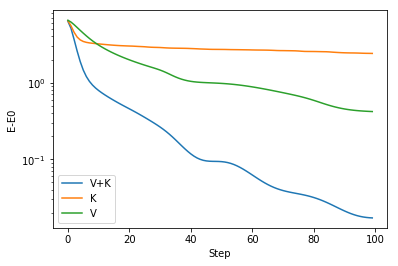

In [0]:
%pylab inline --no-import-all
plt.semilogy(Es.T)
plt.xlabel("Step")
plt.ylabel("E-E0")
plt.legend(['V+K', 'K', 'V'])
plt.savefig("Cooling.pdf")

In [0]:
# Animation, but does not work on CoLab yet.
from mmf_setup.set_path import hgroot
from super_hydro.contexts import NoInterrupt
from IPython.display import clear_output

eg = CoolingEg(dt_Emax=1.0, beta_0=1, beta_V=1, beta_K=1)
psi = 1*psi0
NoInterrupt.unregister()
with NoInterrupt() as interrupted:
    while not interrupted:
        psi = eg.step(psi, 100)
        display(eg.plot(psi))
        clear_output(wait=True)        

ModuleNotFoundError: ignored

## Local Friction

Here we demonstrate how the cooling potential $\op{V}_c$ can be used to implement semi-absorbing boundary conditions.  We simply multiply $V_c(x)$ by a function which only enables this at the boundaries.

In [0]:
class CoolingBoundary(CoolingEg):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.beta_K = 0
        self.mask = np.where(abs(self.x) < 0.8*self.L/2,
                             0.0, 
                             1.0)
    def get_Vc(self, psi):
        return super().get_Vc(psi)*self.mask

$$
  \hbar\dot{n} = \I \psi^\dagger(x)\braket{x|\op{K}|\psi} + \text{h.c.}
$$

In [0]:
eg = CoolingBoundary(beta_V=10.0, dt_Emax=0.1)
psi = 0*eg.x + 1 + 1.0*np.exp(-eg.x**2/2)
NoInterrupt.unregister()
with NoInterrupt() as interrupted:
    while not interrupted:
        psi = eg.step(psi, 1000)
        display(eg.plot(psi))
        clear_output(wait=True)        